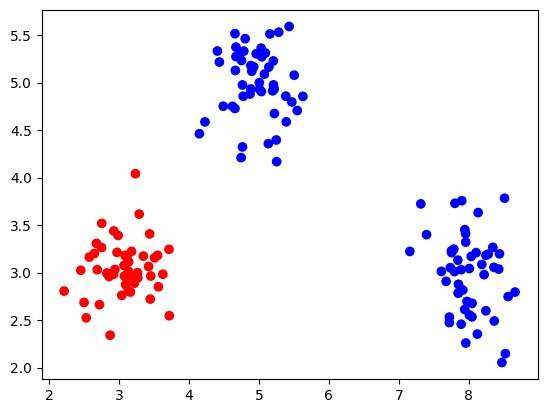

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


N1 = 50
N2 = 50
N3 = 50
K = 2
sigma = 0.1


mean = (3,3)
cov = [[sigma, 0], [0, sigma]]
X1 = np.random.multivariate_normal(mean, cov, N1)
c1 = [ 'red'] * len(X1)

mean = (5,5)
X2 = np.random.multivariate_normal(mean, cov, N2)
c2 = ['blue'] * len(X2)

mean = (8,3)
X3 = np.random.multivariate_normal(mean, cov, N3)
c3 = ['blue'] * len(X3)

X = np.concatenate( (X1, X2, X3))
color = np.concatenate((c1, c2, c3) )

T = np.zeros([len(X),K])
for n in range(0,len(X)):
    if(n < len(X1)) :
        T[n][0] = 1
    if(n >= N1 and n < len(X1) + len(X2) + len(X3)):
        T[n][1] = 1
        
T = T.astype (int)


plt.scatter(X[:, 0], X[:, 1], marker = 'o', c = color )
plt.show( )

In [ ]:
# predictive_classification

def predictive_clf(x, M):
    
    